# Paid Media Marketing Science Project
## Conversion Response Modeling + Marginal ROAS Optimization (Portfolio/Interview Notebook)

**Dataset:** `ppc_campaign_performance_data.csv`  
**Goal:** Diagnose performance, fit a conversion response model with diminishing returns, derive marginal ROAS, and simulate budget reallocation.


## 0. Setup
Import libraries, set display options, and load the dataset.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ppc_campaign_performance_data.csv to ppc_campaign_performance_data (1).csv


In [3]:
df = pd.read_csv("ppc_campaign_performance_data.csv")
df.head()

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,Carousel,35-44,Male,Europe,27840,6453.9,4.31,2025-01-19,8698
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,Text,55+,Male,Africa,128076,10067.4,12.72,2025-01-22,4496
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,Video,35-44,Other,North America,193980,7623.0,25.45,2024-07-23,7935
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,Text,25-34,Male,North America,24024,8504.2,2.82,2024-04-20,4620
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,Text,25-34,Other,Europe,277032,8046.5,34.43,2024-08-07,5235


## 1. Quick data overview
We check shape, dtypes, and summary stats to understand what’s available.

In [4]:
print("Shape:", df.shape)
display(df.head(3))
display(pd.DataFrame({"col": df.columns, "dtype": df.dtypes.astype(str)}))



Shape: (1000, 19)


,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,Carousel,35-44,Male,Europe,27840,6453.9,4.31,2025-01-19,8698
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,Text,55+,Male,Africa,128076,10067.4,12.72,2025-01-22,4496
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,Video,35-44,Other,North America,193980,7623.0,25.45,2024-07-23,7935


,col,dtype
Campaign_ID,Campaign_ID,object
Budget,Budget,int64
Clicks,Clicks,int64
CTR,CTR,float64
CPC,CPC,float64
Conversions,Conversions,int64
CPA,CPA,float64
Conversion_Rate,Conversion_Rate,float64
Duration,Duration,int64
Platform,Platform,object


In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

## 2. Data quality & KPI validation
Datasets include derived KPIs (CTR/CPC/CPA/CVR/ROAS). We verify they match raw fields.

- **CTR** = Clicks / Impressions
- **CPC** = Spend / Clicks
- **CVR** = Conversions / Clicks
- **CPA** = Spend / Conversions
- **ROAS** = Revenue / Spend

Small differences (e.g., ~2–3%) are common due to rounding or reporting tolerance.

In [6]:

# Recompute metrics from raw fields
df["ctr_calc"]  = df["Clicks"] / df["Impressions"].replace(0, np.nan)
df["cpc_calc"]  = df["Spend"] / df["Clicks"].replace(0, np.nan)
df["cvr_calc"]  = df["Conversions"] / df["Clicks"].replace(0, np.nan)
df["cpa_calc"]  = df["Spend"] / df["Conversions"].replace(0, np.nan)
df["roas_calc"] = df["Revenue"] / df["Spend"].replace(0, np.nan)

metric_checks = pd.DataFrame({
    "CTR_mean_abs_diff":  (df["CTR"] - df["ctr_calc"]).abs().mean(),
    "CPC_mean_abs_diff":  (df["CPC"] - df["cpc_calc"]).abs().mean(),
    "CVR_mean_abs_diff":  (df["Conversion_Rate"] - df["cvr_calc"]).abs().mean(),
    "CPA_mean_abs_diff":  (df["CPA"] - df["cpa_calc"]).abs().mean(),
    "ROAS_mean_abs_diff": (df["ROAS"] - df["roas_calc"]).abs().mean(),
}, index=["mean_abs_diff"]).T

display(metric_checks)

# Relative (percent) differences for CPC and CPA
rel_err_cpc = (df["CPC"] - df["cpc_calc"]).abs().mean() / df["CPC"].mean()
rel_err_cpa = (df["CPA"] - df["cpa_calc"]).abs().mean() / df["CPA"].mean()
rel_err_ctr = (df["CTR"] - df["ctr_calc"]).abs().mean() / df["CTR"].mean()
rel_err_cvr = (df["Conversion_Rate"] - df["cvr_calc"]).abs().mean()/ df["Conversion_Rate"].mean()
rel_err_roas = (df["ROAS"] - df["roas_calc"]).abs().mean() / df["ROAS"].mean()
print(f"Relative error: CPC ~ {rel_err_cpc:.2%}, CPA ~ {rel_err_cpa:.2%}, CTR ~ {rel_err_ctr:.2%}, CVR ~ {rel_err_cvr:.2%}, ROAS ~ {rel_err_roas:.2%}")


,mean_abs_diff
CTR_mean_abs_diff,0.000051
CPC_mean_abs_diff,0.308296
CVR_mean_abs_diff,0.000024
CPA_mean_abs_diff,1.127161
ROAS_mean_abs_diff,0.002531


Relative error: CPC ~ 2.75%, CPA ~ 2.75%, CTR ~ 0.02%, CVR ~ 0.00%, ROAS ~ 0.02%


### KPI decision
KPI validation showed minor rounding differences (≈2–3%) between provided and recalculated metrics. These differences are immaterial and within expected reporting tolerance for paid media data. Therefore, provided KPIs were used for analysis.

Next, we build an overall KPI dashboard.

In [7]:

tot = df[["Spend","Revenue","Impressions","Clicks","Conversions","Budget"]].sum()

overall = pd.Series({
    "Spend": tot["Spend"],
    "Revenue": tot["Revenue"],
    "ROAS (calc)": tot["Revenue"]/tot["Spend"],
    "Impressions": tot["Impressions"],
    "Clicks": tot["Clicks"],
    "CTR (calc)": tot["Clicks"]/tot["Impressions"],
    "Conversions": tot["Conversions"],
    "CVR (calc)": tot["Conversions"]/tot["Clicks"],
    "CPC (calc)": tot["Spend"]/tot["Clicks"],
    "CPA (calc)": tot["Spend"]/tot["Conversions"],
    "Budget Utilization (Spend/Budget)": tot["Spend"]/tot["Budget"],
})
overall


,0
Spend,5.956168e+06
Revenue,5.988671e+07
ROAS (calc),1.005457e+01
Impressions,5.497177e+06
Clicks,1.013229e+06
CTR (calc),1.843181e-01
Conversions,5.056720e+05
CVR (calc),4.990698e-01
CPC (calc),5.878402e+00
CPA (calc),1.177872e+01


## 3. Segment performance (where is spend going?)
We summarize performance by key dimensions:
- Platform
- Region
- Content Type

We compute: Spend share, Budget utilization, ROAS/CPA and funnel metrics.

In [8]:

def summarize(df_in: pd.DataFrame, by: str) -> pd.DataFrame:
    g = (df_in.groupby(by, dropna=False)
           .agg(Spend=("Spend","sum"),
                Revenue=("Revenue","sum"),
                Impressions=("Impressions","sum"),
                Clicks=("Clicks","sum"),
                Conversions=("Conversions","sum"),
                Budget=("Budget","sum"))
           .reset_index())
    g["Spend_Share"] = g["Spend"] / g["Spend"].sum()
    g["Budget_Util"] = g["Spend"] / g["Budget"].replace(0, np.nan)

    # Use calc metrics for consistency
    g["ROAS"] = g["Revenue"] / g["Spend"].replace(0, np.nan)
    g["CTR"]  = g["Clicks"] / g["Impressions"].replace(0, np.nan)
    g["CVR"]  = g["Conversions"] / g["Clicks"].replace(0, np.nan)
    g["CPC"]  = g["Spend"] / g["Clicks"].replace(0, np.nan)
    g["CPA"]  = g["Spend"] / g["Conversions"].replace(0, np.nan)
    return g.sort_values("Spend", ascending=False)

platform = summarize(df, "Platform")
region   = summarize(df, "Region")
content  = summarize(df, "Content_Type")

display(platform)
display(region)
display(content)


,Platform,Spend,Revenue,Impressions,Clicks,Conversions,Budget,Spend_Share,Budget_Util,ROAS,CTR,CVR,CPC,CPA
3,LinkedIn,1347518.5,13426760,1302909,236744,114614,1349970,0.226239,0.998184,9.964064,0.181704,0.484126,5.691880,11.757015
0,Facebook,1233654.8,13846011,1053727,209241,110760,1233780,0.207122,0.999899,11.223570,0.198572,0.529342,5.895856,11.138090
2,Instagram,1160623.2,11063115,1078363,186670,91304,1162500,0.194861,0.998386,9.532047,0.173105,0.489120,6.217513,12.711636
4,YouTube,1119159.1,10131868,1013372,188916,89753,1120310,0.187899,0.998973,9.053108,0.186423,0.475095,5.924110,12.469322
1,Google,1095212.2,11418956,1048806,191658,99241,1095430,0.183879,0.999801,10.426250,0.182739,0.517803,5.714409,11.035884


,Region,Spend,Revenue,Impressions,Clicks,Conversions,Budget,Spend_Share,Budget_Util,ROAS,CTR,CVR,CPC,CPA
0,Africa,1230621.7,9733560,1173772,206676,92073,1230280,0.206613,1.000278,7.909466,0.176078,0.445494,5.954352,13.365717
3,North America,1211399.9,12586455,1130302,202039,102702,1208100,0.203386,1.002731,10.390008,0.178748,0.508328,5.995872,11.795290
2,Europe,1191666.3,12499743,1097096,204957,101181,1192990,0.200073,0.998890,10.489298,0.186818,0.493669,5.814226,11.777570
1,Asia,1174890.5,12572794,988965,193464,106551,1180340,0.197256,0.995383,10.701247,0.195623,0.550754,6.072915,11.026555
4,South America,1147589.4,12494158,1107042,206093,103165,1150280,0.192672,0.997661,10.887307,0.186165,0.500575,5.568308,11.123825


,Content_Type,Spend,Revenue,Impressions,Clicks,Conversions,Budget,Spend_Share,Budget_Util,ROAS,CTR,CVR,CPC,CPA
0,Carousel,1567257.1,16852746,1448373,267354,138291,1570050,0.263132,0.998221,10.753019,0.184589,0.517258,5.862105,11.333038
2,Text,1507385.4,13469873,1370455,251836,117567,1514720,0.253080,0.995158,8.935918,0.183761,0.466840,5.985583,12.821501
1,Image,1446641.3,14051159,1307809,245270,120500,1444210,0.242881,1.001683,9.712953,0.187543,0.491295,5.898158,12.005322
3,Video,1434884.0,15512932,1370540,248769,129314,1433010,0.240907,1.001308,10.811280,0.181512,0.519816,5.767937,11.096123


## 4. Root-cause lens: CPA = CPC / CVR
A simple but powerful diagnostic identity:

\[ CPA = \frac{CPC}{CVR} \]

- High CPA driven by **CPC** ⇒ auction/competition
- High CPA driven by **CVR** ⇒ traffic quality / landing page / offer

We visualize platform-level CPA vs CPC and CPA vs CVR.

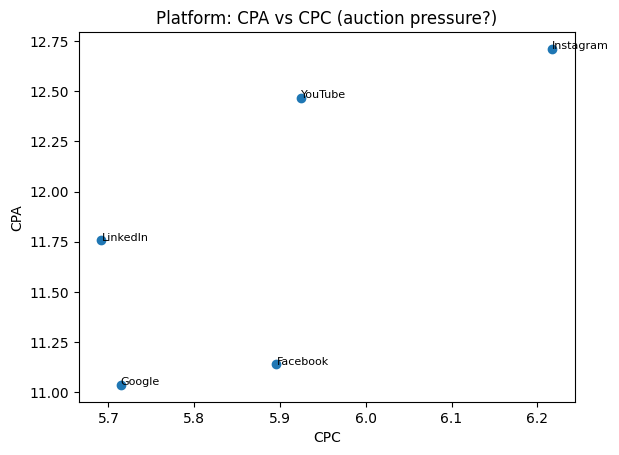

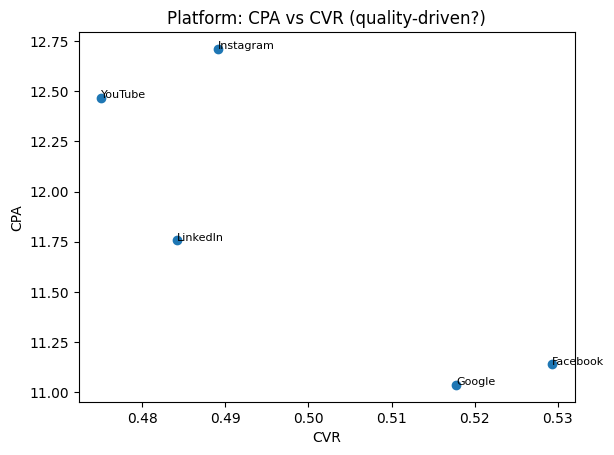

In [9]:

plt.figure()
plt.scatter(platform["CPC"], platform["CPA"])
for _, r in platform.iterrows():
    plt.text(r["CPC"], r["CPA"], str(r["Platform"]), fontsize=8)
plt.xlabel("CPC")
plt.ylabel("CPA")
plt.title("Platform: CPA vs CPC (auction pressure?)")
plt.show()

plt.figure()
plt.scatter(platform["CVR"], platform["CPA"])
for _, r in platform.iterrows():
    plt.text(r["CVR"], r["CPA"], str(r["Platform"]), fontsize=8)
plt.xlabel("CVR")
plt.ylabel("CPA")
plt.title("Platform: CPA vs CVR (quality-driven?)")
plt.show()


## 5. Time trends (weekly monitoring)
We aggregate by week to inspect KPI movement over time.

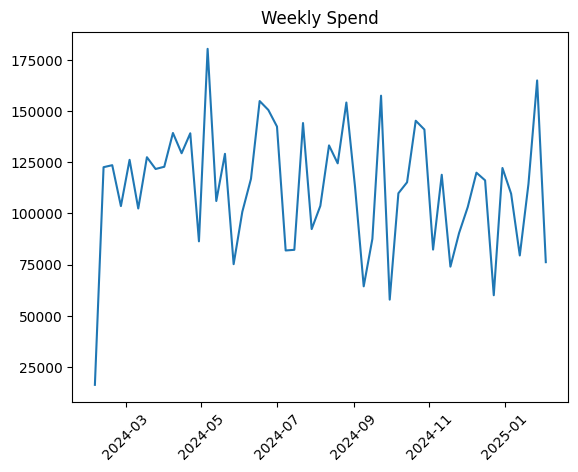

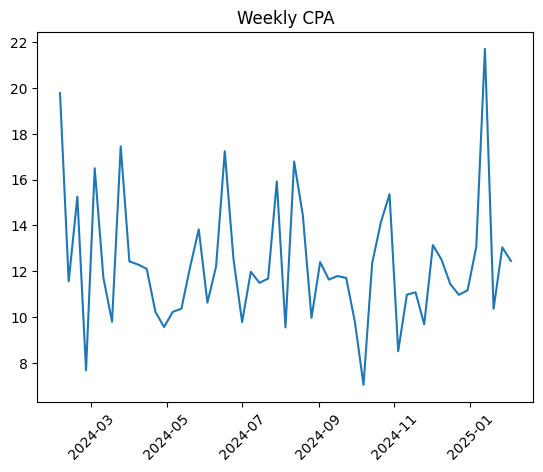

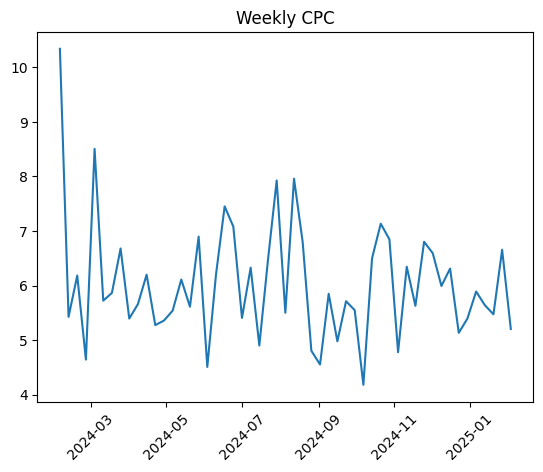

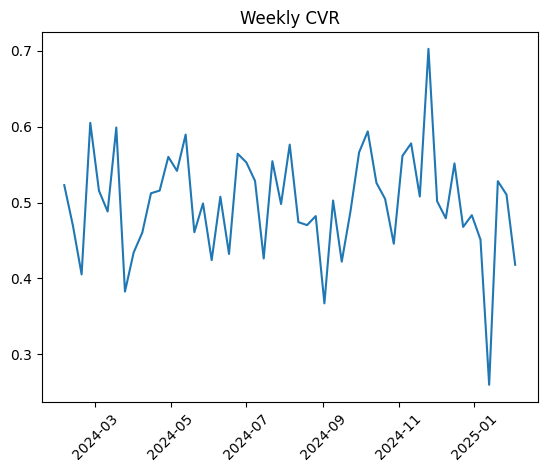

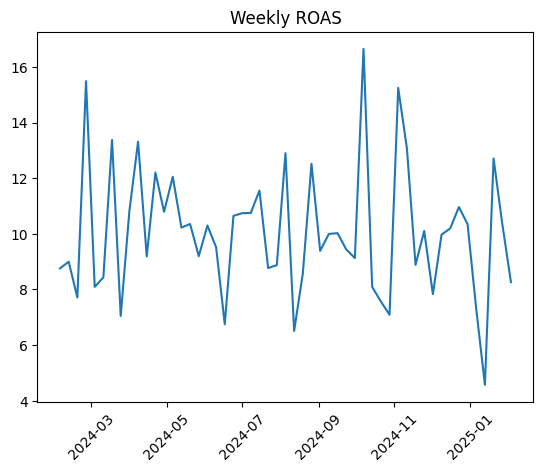

In [10]:

df["week"] = df["Date"].dt.to_period("W").dt.start_time

wk = (df.groupby("week", as_index=False)
        .agg(Spend=("Spend","sum"),
             Revenue=("Revenue","sum"),
             Impressions=("Impressions","sum"),
             Clicks=("Clicks","sum"),
             Conversions=("Conversions","sum")))

wk["ROAS"] = wk["Revenue"]/wk["Spend"]
wk["CTR"]  = wk["Clicks"]/wk["Impressions"]
wk["CVR"]  = wk["Conversions"]/wk["Clicks"]
wk["CPC"]  = wk["Spend"]/wk["Clicks"]
wk["CPA"]  = wk["Spend"]/wk["Conversions"]

def plot_series(x, y, title):
    plt.figure()
    plt.plot(x, y)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_series(wk["week"], wk["Spend"], "Weekly Spend")
plot_series(wk["week"], wk["CPA"], "Weekly CPA")
plot_series(wk["week"], wk["CPC"], "Weekly CPC")
plot_series(wk["week"], wk["CVR"], "Weekly CVR")
plot_series(wk["week"], wk["ROAS"], "Weekly ROAS")


## 6. Conversion response model (Poisson GLM)
Instead of modeling CPA (a noisy ratio), we model **Conversions** (count outcome) as a function of log spend + controls.

Model:
\[ Conversions \sim \log(Spend) + Platform + Content + Region + Age + Gender \]

With log link:
\[ E[Conversions] \propto Spend^{\beta} \]

So \(\beta\) is an elasticity: 1% more spend ⇒ ~\(\beta\)% more conversions.

In [11]:

df_m = df[(df["Spend"] > 0) & (df["Conversions"] >= 0)].copy()
df_m["log_spend"] = np.log(df_m["Spend"])

formula = "Conversions ~ log_spend + C(Platform) + C(Content_Type) + C(Region) + C(Target_Age) + C(Target_Gender)"
pois = smf.glm(formula=formula, data=df_m, family=sm.families.Poisson()).fit()

print(pois.summary())
beta = float(pois.params["log_spend"])
print("\nElasticity beta (log_spend):", beta)


                 Generalized Linear Model Regression Results                  
Dep. Variable:            Conversions   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      981
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7489e+05
Date:                Sat, 07 Feb 2026   Deviance:                   3.4221e+05
Time:                        23:40:28   Pearson chi2:                 3.42e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## 7. Interpreting coefficients (multiplicative effects)
Because this is a log-link model, coefficients can be interpreted as multiplicative effects on expected conversions:

- A coefficient \(c\) corresponds to a multiplier \(e^c\)
- Example: c = -0.20 ⇒ multiplier ≈ 0.82 ⇒ ~18% lower conversions vs baseline (holding spend & controls constant)

Let’s compute multipliers for Platform, Content, Region, Age, Gender.

In [12]:

params = pois.params
conf = pois.conf_int()
tbl = pd.DataFrame({
    "coef": params,
    "multiplier": np.exp(params),
    "ci_low": conf[0],
    "ci_high": conf[1],
    "multiplier_ci_low": np.exp(conf[0]),
    "multiplier_ci_high": np.exp(conf[1]),
})
# Drop intercept for readability
tbl = tbl.drop(index=["Intercept"], errors="ignore").sort_values("multiplier")
tbl.head(25)


,coef,multiplier,ci_low,ci_high,multiplier_ci_low,multiplier_ci_high
C(Platform)[T.YouTube],-0.197331,0.820918,-0.206198,-0.188465,0.813672,0.828230
C(Platform)[T.Instagram],-0.188738,0.828003,-0.197587,-0.179890,0.820709,0.835362
C(Content_Type)[T.Text],-0.130563,0.877601,-0.138380,-0.122746,0.870768,0.884488
C(Target_Age)[T.35-44],-0.086290,0.917328,-0.095231,-0.077350,0.909163,0.925566
C(Platform)[T.LinkedIn],-0.080833,0.922348,-0.089134,-0.072532,0.914723,0.930036
C(Target_Age)[T.55+],-0.060656,0.941147,-0.069273,-0.052040,0.933072,0.949291
C(Target_Age)[T.25-34],-0.059409,0.942321,-0.068069,-0.050749,0.934196,0.950517
C(Target_Age)[T.45-54],-0.027951,0.972436,-0.036418,-0.019485,0.964237,0.980704
C(Platform)[T.Google],-0.019090,0.981091,-0.027704,-0.010476,0.972676,0.989578
C(Content_Type)[T.Image],-0.007759,0.992271,-0.015551,0.000034,0.984569,1.000034


## 8. Build platform response curves & marginal ROAS
We convert the fitted model into a platform-level response curve of the form:

\[ mu_p(S) = A_p * S^{beta} \]

Where:
- \(beta) comes from the model (log_spend coefficient)
- \(A_p) is a platform-specific constant estimated from predictions

Marginal conversions per dollar:
\[ \{dmu}/{dS} = beta * {mu}/{S} \]

Marginal ROAS:
\[ mROAS = {dmu}/{dS} * (Revenue_per_Conversion) \]

We’ll estimate these per platform at the *current* spend level.

In [13]:

# Predict expected conversions (mu) at observed spend
df_m["mu_hat"] = pois.predict(df_m)

# Estimate platform response curve constant A_p: mu = A_p * Spend^beta
df_m["A_i"] = df_m["mu_hat"] / (df_m["Spend"] ** beta)
A_p = df_m.groupby("Platform")["A_i"].mean()

# Current spend per platform
S0 = df_m.groupby("Platform")["Spend"].sum()

# Revenue per conversion by platform (robust median)
df_m["rpc"] = df_m["Revenue"] / df_m["Conversions"].replace(0, np.nan)
rpc_p = df_m.groupby("Platform")["rpc"].median()

def compute_platform_metrics(spend_by_platform: pd.Series) -> pd.DataFrame:
    s = spend_by_platform.copy().astype(float)
    out = pd.DataFrame({"Platform": s.index, "Spend": s.values})
    out["A"] = out["Platform"].map(A_p).astype(float)
    out["rpc_median"] = out["Platform"].map(rpc_p).astype(float)

    out["pred_conv"] = out["A"] * (out["Spend"] ** beta)
    out["pred_rev"]  = out["pred_conv"] * out["rpc_median"]

    out["marg_conv_per_$"] = beta * out["pred_conv"] / out["Spend"]
    out["marg_roas"] = out["marg_conv_per_$"] * out["rpc_median"]
    return out

platform_metrics = compute_platform_metrics(S0).sort_values("marg_roas", ascending=False)
platform_metrics


,Platform,Spend,A,rpc_median,pred_conv,pred_rev,marg_conv_per_$,marg_roas
1,Google,1095212.2,166.278653,119.0,1117.726613,133009.466927,0.000140,0.016640
0,Facebook,1233654.8,170.690859,122.0,1166.251935,142282.736091,0.000130,0.015802
4,YouTube,1119159.1,141.904437,122.0,956.713988,116719.106548,0.000117,0.014289
3,LinkedIn,1347518.5,156.971792,117.5,1085.567956,127554.234780,0.000110,0.012970
2,Instagram,1160623.2,140.734787,113.5,953.569514,108230.139797,0.000113,0.012777


## 9. Budget reallocation simulation (equalize marginal ROAS)
**Optimization logic:** move incremental budget from the lowest marginal ROAS platform to the highest marginal ROAS platform.

As you add spend to the best platform, it saturates → marginal ROAS falls. As you remove spend from the worst platform, its marginal ROAS rises. The process stops (or converges) when marginal ROAS is closer across platforms.

I’ll simulate reallocating **10% of total spend** in steps (e.g., $20k per step).

In [14]:

def totals(m: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "total_spend": m["Spend"].sum(),
        "total_pred_conv": m["pred_conv"].sum(),
        "total_pred_rev": m["pred_rev"].sum(),
        "avg_roas_pred": m["pred_rev"].sum() / m["Spend"].sum()
    })

def reallocate_budget(spend0: pd.Series, move_frac: float = 0.10, step: float = 20000.0):
    spend = spend0.copy().astype(float)
    total_move = float(spend.sum() * move_frac)
    moved = 0.0

    moved_from = {p: 0.0 for p in spend.index}
    moved_to   = {p: 0.0 for p in spend.index}

    while moved < total_move - 1e-9:
        metrics = compute_platform_metrics(spend).sort_values("marg_roas", ascending=False).reset_index(drop=True)
        best = metrics.loc[0, "Platform"]
        worst = metrics.loc[len(metrics)-1, "Platform"]

        amt = min(step, total_move - moved, spend[worst])
        if amt <= 0:
            break

        spend[worst] -= amt
        spend[best]  += amt
        moved += amt

        moved_from[worst] += amt
        moved_to[best] += amt

    after = compute_platform_metrics(spend)
    after["delta_spend"] = after["Platform"].map(moved_to) - after["Platform"].map(moved_from)
    return after, moved

before = compute_platform_metrics(S0)
after, moved_amt = reallocate_budget(S0, move_frac=0.10, step=20000.0)

print("Total budget moved:", moved_amt)

totals_table = pd.DataFrame([totals(before), totals(after)], index=["Before", "After"])
display(totals_table)

comp = before.set_index("Platform")[["Spend","pred_conv","pred_rev","marg_roas"]].join(
    after.set_index("Platform")[["Spend","pred_conv","pred_rev","marg_roas","delta_spend"]],
    lsuffix="_before", rsuffix="_after"
)
comp["delta_pred_conv"] = comp["pred_conv_after"] - comp["pred_conv_before"]
comp["delta_pred_rev"]  = comp["pred_rev_after"]  - comp["pred_rev_before"]
comp = comp.reset_index().sort_values("delta_spend", ascending=False)

comp


Total budget moved: 595616.7800000001


,total_spend,total_pred_conv,total_pred_rev,avg_roas_pred
Before,5956167.8,5279.830005,627795.684143,0.105403
After,5956167.8,5283.019180,628342.582518,0.105494


,Platform,Spend_before,pred_conv_before,pred_rev_before,marg_roas_before,Spend_after,pred_conv_after,pred_rev_after,marg_roas_after,delta_spend,delta_pred_conv,delta_pred_rev
1,Google,1095212.2,1117.726613,133009.466927,0.016640,1279595.42,1141.811118,135875.523073,0.014549,184383.22,24.084505,2866.056147
0,Facebook,1233654.8,1166.251935,142282.736091,0.015802,1373654.80,1183.555855,144393.814295,0.014402,140000.00,17.303920,2111.078204
4,YouTube,1119159.1,956.713988,116719.106548,0.014289,1099159.10,954.353182,116431.088205,0.014514,-20000.00,-2.360806,-288.018344
2,Instagram,1160623.2,953.569514,108230.139797,0.012777,1016239.98,936.369605,106277.950157,0.014329,-144383.22,-17.199909,-1952.189640
3,LinkedIn,1347518.5,1085.567956,127554.234780,0.012970,1187518.50,1066.929419,125364.206788,0.014464,-160000.00,-18.638536,-2190.027992


### Visualize marginal ROAS before vs after

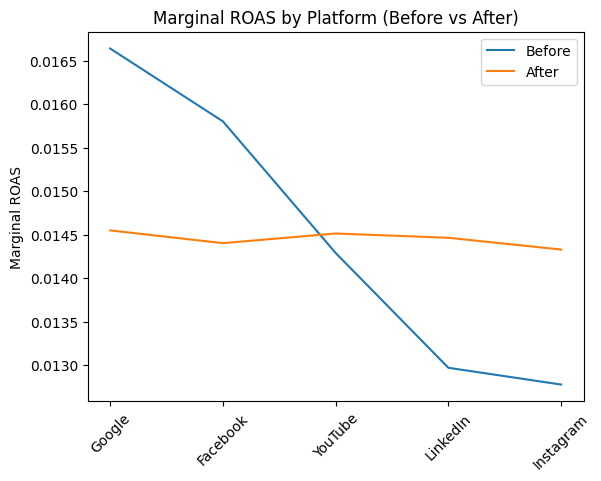

,Before,After
Platform,,
Google,0.016640,0.014549
Facebook,0.015802,0.014402
YouTube,0.014289,0.014514
LinkedIn,0.012970,0.014464
Instagram,0.012777,0.014329


In [15]:

b = before.set_index("Platform")["marg_roas"]
a = after.set_index("Platform")["marg_roas"]

plot_df = pd.DataFrame({"Before": b, "After": a}).sort_values("Before", ascending=False)

plt.figure()
x = np.arange(len(plot_df))
plt.plot(x, plot_df["Before"].values, label="Before")
plt.plot(x, plot_df["After"].values, label="After")
plt.xticks(x, plot_df.index, rotation=45)
plt.ylabel("Marginal ROAS")
plt.title("Marginal ROAS by Platform (Before vs After)")
plt.legend()
plt.show()

plot_df
